Imports

In [1]:
# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils
from torchvision.io import read_image
import torchvision.datasets as datasets
import torchvision.models as models

# other imports
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import itertools
from distutils.dir_util import copy_tree
from sklearn.metrics import confusion_matrix
from time import perf_counter
from PIL import Image

Mount google drive for datasets


In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls
BASE_PATH = "drive/My Drive/sidewalk_cv/"
os.chdir(BASE_PATH)
if not os.path.exists('crops/'):
  !unzip sidewalk_cv_medium_dataset.zip
!ls
os.chdir('/content')

# Move file from gdrive to remote runtime disk
# copy_tree("drive/MyDrive/sidewalk_cv/crops/", "/")

Streaming output truncated to the last 5000 lines.
  inflating: crops/null_45453.jpg    
  inflating: crops/null_45454.jpg    
  inflating: crops/null_45455.jpg    
  inflating: crops/null_45456.jpg    
  inflating: crops/null_45457.jpg    
  inflating: crops/null_45458.jpg    
  inflating: crops/null_45459.jpg    
  inflating: crops/null_45460.jpg    
  inflating: crops/null_45461.jpg    
  inflating: crops/null_45462.jpg    
  inflating: crops/null_45463.jpg    
  inflating: crops/null_45464.jpg    
  inflating: crops/null_45465.jpg    
  inflating: crops/null_45466.jpg    
  inflating: crops/null_45467.jpg    
  inflating: crops/null_45468.jpg    
  inflating: crops/null_45469.jpg    
  inflating: crops/null_45470.jpg    
  inflating: crops/null_45471.jpg    
  inflating: crops/null_45472.jpg    
  inflating: crops/null_45473.jpg    
  inflating: crops/null_45474.jpg    
  inflating: crops/null_45475.jpg    
  inflating: crops/null_45476.jpg    
  inflating: crops/null_45477.jpg    

Check GPU

In [3]:
if torch.cuda.is_available():  
  dev = "cuda" 
else:  
  dev = "cpu"
device = torch.device(dev) 
print(device)

cuda


Load Dataset and partition into training, validation, and test sets

In [4]:
class SidewalkCropsDataset(Dataset):
  def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = Image.open(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    return image, label

image_transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

batch_size = 96

labels_csv_path = "/content/drive/MyDrive/sidewalk_cv/crop_info.csv"
img_dir = "/content/drive/MyDrive/sidewalk_cv/crops"
# train_labels_csv_path = "/content/drive/MyDrive/sidewalk_cv/train_crop_info_1.csv"
# train_img_dir = "/content/drive/MyDrive/sidewalk_cv/train_crops_1000"

# test_labels_csv_path = "/content/drive/MyDrive/sidewalk_cv/test_crop_info.csv"
# test_img_dir = "/content/drive/MyDrive/sidewalk_cv/test_crops"

# load our custom sidewalk crop dataset
#train_set = SidewalkCropsDataset(train_labels_csv_path, train_img_dir, image_transform)
dataset = SidewalkCropsDataset(labels_csv_path, img_dir, image_transform)

# partition dataset into 80/10/10 split for train/validation/test
k = .8
dataset_size = len(dataset)
train_size = int(k * dataset_size)
val_size = int((dataset_size - train_size) / 2)
test_size = dataset_size - train_size - val_size
print(dataset_size)
print(train_size)
print(val_size)
print(test_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

# Do we want a dedicated test set?
# test_dataset = SidewalkCropsDataset(test_labels_csv_path, test_img_dir, image_transform)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

50449
40359
5045
5045
40359
5045
5045


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Visualize inputs

In [ ]:
#  for inputs, labels in test_dataloader:
#    print(inputs.shape)
#    plt.figure()
#    plt.imshow(torch.squeeze(inputs).permute(1, 2, 0))
#    plt.show()
#    print(labels)

In [35]:
def save_training_checkpoint(model, best_model_state, optimizer, scheduler, loss_train, loss_validation, epoch, path):
  # add things like TPR, FPR later when we start evaluating them
  torch.save({'model_state': model.state_dict(),
              'best_model_state': best_model_state,
              'optimizer_state': optimizer.state_dict(),
              'scheduler_state': scheduler.state_dict(),
              'loss_train': loss_train,
              'loss_validation': loss_validation,
              'epoch': epoch
              }, path)
  print("saved")
  
def load_training_checkpoint(model, optimizer, scheduler, path):
  if not os.path.isfile(path):
    return [], [], -1 #training starts at last epoch + 1
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state'])
  optimizer.load_state_dict(checkpoint['optimizer_state'])
  scheduler.load_state_dict(checkpoint['scheduler_state'])
  return checkpoint['loss_train'], checkpoint['loss_validation'], checkpoint['epoch']
  
def load_best_weights(model, path):
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['best_model_state'])

define train function

In [40]:
def train(model, optimizer, scheduler, loss_func, epochs, datasetLoaders, save_path, loss_train, loss_validation, start_epoch):
  t_start = perf_counter()

  best_model_state = copy.deepcopy(model.state_dict())

  for epoch in range(start_epoch, epochs):
    print("Epoch " + str(epoch) + " out of " + str(epochs))
    for mode in ['training', 'validation']:
      if mode == "training":
        # Set model to training mode.
        model.train()
      else:
        # Set model to evaluation mode for validation set.
        model.eval()

      # Get length of dataset for current mode
      n = len(datasetLoaders[mode].dataset)

      # Sum of losses over batches.
      total_loss = 0

      # Number of correct predictions.
      total_correct = 0

      epoch_count = 0
      
      for inputs, labels in datasetLoaders[mode]:
        inputs, labels = inputs.to(device), labels.to(device)
        epoch_count += inputs.size(0)
        print("percent {}".format(epoch_count / n))
        # For code brevity, we'll set the reset gradients for model params
        # with the intention of using it for training.
        # We'll use the set_grad_enabled to toggle whether we actually use the
        # gradient for training/validation.
        # https://pytorch.org/docs/stable/generated/torch.set_grad_enabled.html
        optimizer.zero_grad()
        use_grad = (mode == 'training')
        with torch.set_grad_enabled(use_grad):
          outputs = model(inputs)
          loss = loss_func(outputs, labels)
          _, preds = torch.max(outputs, 1)
          if use_grad:
            # We are training, so make sure to actually
            # train by using loss/stepping.
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * inputs.size(0) # Averages over batch              
        total_correct += (preds == labels.data).sum().item() # what is .data for?

      # Calculate average loss over batches
      loss_avg = total_loss / n

      # Calculate accuracy
      accuracy = total_correct / n
      
      print("mode: " + mode + ", accuracy: " + str(accuracy) + ", loss: " + str(loss_avg))

      if mode == 'validation':
        # Record validation loss
        loss_validation.append(loss_avg)

        if accuracy > np.max(loss_validation):
          # We found a better accuracy with these new weights, so save them
          best_model_state = copy.deepcopy(model.state_dict())

      else:
        # Record training accuracy
        loss_train.append(loss_avg)

        # make sure to step through lr update schedule
        #scheduler.step()
    
    save_training_checkpoint(model, best_model_state, optimizer, scheduler, loss_train, loss_validation, epoch, save_path)
      
    
    print("\n")

  t_stop = perf_counter()
  print("Elapsed time during training in seconds",
                                        t_stop-t_start)
  # Set our model with best weights
  model.load_state_dict(best_model_state)
  return model, best_validation_accuracy, loss_train, loss_validation

define evaluation function

In [19]:
def evaluate(model, loss_func, dataset_loader, test=False):
  # Length of data set we are evaluating on.
  n = len(dataset_loader.dataset)

  # Initialize the prediction and label lists(tensors) for our confusion matrix
  predlist=torch.zeros(0, dtype=torch.long, device='cpu')
  lbllist=torch.zeros(0, dtype=torch.long, device='cpu')
  conf_mat = None

  # Correct predictions.
  correct = 0
  total_loss = 0
  with torch.no_grad():
    for inputs, labels in dataset_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = loss_func(outputs, labels)
      _, predictions = torch.max(outputs, 1)

      # Append batch prediction results and labels
      predlist=torch.cat([predlist, predictions.view(-1).cpu()])
      lbllist=torch.cat([lbllist, labels.view(-1).cpu()])

      total_loss += loss.item() * inputs.size(0) # Weighted average with size?
      correct += (predictions == labels).sum().item() # what is labels.data

  if test:
    # Display a Confusion matrix
    conf_mat = confusion_matrix(lbllist.numpy(), predlist.numpy())
    print(conf_mat)

  return  correct / n, total_loss / n, conf_mat

Add Data Visualization Functions

In [20]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Get ResNet50 for Fine Tuning (Transfer Learning)

In [41]:
resnet50 = torchvision.models.resnet50(pretrained = True).to(device)
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 5) # (1,2,3,4) for label types, 0 for null crops 

lr = 0.01

resnet50.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 10, gamma=0.1)
checkpoint_save_path = BASE_PATH + "training_test_saves"

Train resnet for 25 epochs


In [ ]:
epochs = 20
dataLoaders = {
  "training": train_dataloader,
  "validation": val_dataloader
}
loss_train, loss_validation, last_epoch = load_training_checkpoint(resnet50, optimizer, scheduler, checkpoint_save_path)
print("training losses: " + str(loss_train))
print("validation losses: " + str(loss_validation))
print("next epoch: " + str(last_epoch + 1))
print("resuming training...\n")

resnet50, best_validation_accuracy, loss_train, loss_validation = train(resnet50, optimizer, scheduler, loss_func, epochs, dataLoaders, checkpoint_save_path, loss_train, loss_validation, last_epoch + 1)
print("Best validation accuracy: ", best_validation_accuracy)

training losses: [0.012998093922838424]
validation losses: [4150899507881314.5]
next epoch: 1
resuming training...

Epoch 1 out of 20


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


percent 0.0023786516018731883
percent 0.004757303203746377
percent 0.007135954805619564
percent 0.009514606407492753
percent 0.01189325800936594
percent 0.014271909611239128


Visualization of training and validation loss over epochs

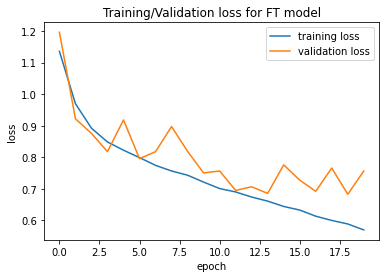

In [ ]:
plt.plot(np.arange(epochs), loss_train, label="training loss")
plt.plot(np.arange(epochs), loss_validation, label="validation loss")
plt.title("Training/Validation loss for FT model")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

Load existing trained models (run this instead of the training block for just evaluation)

In [ ]:
resnet50_pretrained = torchvision.models.resnet50(pretrained = True).to(device)
num_ftrs = resnet50_pretrained.fc.in_features
resnet50_pretrained.fc = nn.Linear(num_ftrs, 5) # (1,2,3,4) for label types, 0 for null crops 
resnet50_pretrained.load_state_dict(torch.load("drive/My Drive/sidewalk_cv/ft_resnet50.pt"))
resnet50_pretrained.to(device)

loss_func = nn.CrossEntropyLoss()

Evaluate resnet on test dataset for accuracy/loss

[[2793   57   67   25   79]
 [ 206  483   35    7   40]
 [ 169   32  354    4   49]
 [  99    4    6   54    8]
 [ 201   16   24    6  227]]
Test accuracy for ResNet as FT:  0.775222993062438
Test loss for ResNet as FT:  0.6507622864130586
Confusion matrix, without normalization
[[2793   57   67   25   79]
 [ 206  483   35    7   40]
 [ 169   32  354    4   49]
 [  99    4    6   54    8]
 [ 201   16   24    6  227]]


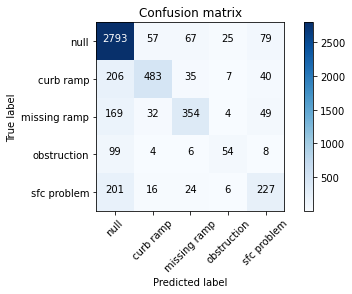

In [ ]:
# Make sure to evaluate on *_pretrained if loading pretrained model
test_accuracy, test_loss, cm = evaluate(resnet50_pretrained, loss_func, test_dataloader, True)
print("Test accuracy for ResNet as FT: ", test_accuracy)
print("Test loss for ResNet as FT: ", test_loss)
# print(train_set.img_labels[:50])
if cm is not None:
  plot_confusion_matrix(cm, ["null", "curb ramp", "missing ramp", "obstruction", "sfc problem"])